# Implementation of the LDA algorithm using Mallet

In [1]:
import re
import nltk
import spacy
import gensim
import logging
import pyLDAvis
import warnings
import numpy as np
import pandas as pd
import pyLDAvis.gensim 
import gensim.corpora as corpora
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
from nltk.corpus import stopwords

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
df = pd.read_excel('posts_sample.xlsx')
df = df[df['main_post'] == 1]

In [3]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

data = df.Body.tolist()

pprint(data[:1])

['Hello I wonder if anyone has any advice. I have had a very stressful few '
 'months in my life. Last week I had breathing problems a shortness of breath '
 'with no pain. I went to urgent care who listened to my lungs and heart and '
 'said it was an anxiety attack. I went to my GP next day who said it was an '
 'anxiety attack to.\n'
 "Since then I have managed to ease the attacks but I've been experiencing "
 'some tingling of and on in left arm. Again a dull pain in left of chest just '
 'above the left breast. Again of and on . Does this sound like a heart attack '
 'is building ? Or could it. E the aftermath of anxiety . \n'
 'I am worried to go back to gp incase I am getting on there nerves.\n'
 'Also would listening in with stethoscope show if there was a problem with '
 'the heart ? \n'
 'Thanks in advance ']


In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), 
                                             deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['hello', 'wonder', 'if', 'anyone', 'has', 'any', 'advice', 'have', 'had', 'very', 'stressful', 'few', 'months', 'in', 'my', 'life', 'last', 'week', 'had', 'breathing', 'problems', 'shortness', 'of', 'breath', 'with', 'no', 'pain', 'went', 'to', 'urgent', 'care', 'who', 'listened', 'to', 'my', 'lungs', 'and', 'heart', 'and', 'said', 'it', 'was', 'an', 'anxiety', 'attack', 'went', 'to', 'my', 'gp', 'next', 'day', 'who', 'said', 'it', 'was', 'an', 'anxiety', 'attack', 'to', 'since', 'then', 'have', 'managed', 'to', 'ease', 'the', 'attacks', 'but', 've', 'been', 'experiencing', 'some', 'tingling', 'of', 'and', 'on', 'in', 'left', 'arm', 'again', 'dull', 'pain', 'in', 'left', 'of', 'chest', 'just', 'above', 'the', 'left', 'breast', 'again', 'of', 'and', 'on', 'does', 'this', 'sound', 'like', 'heart', 'attack', 'is', 'building', 'or', 'could', 'it', 'the', 'aftermath', 'of', 'anxiety', 'am', 'worried', 'to', 'go', 'back', 'to', 'gp', 'incase', 'am', 'getting', 'on', 'there', 'nerves', 'als

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, 
                               threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

['hello', 'wonder_if', 'anyone', 'has', 'any_advice', 'have', 'had', 'very', 'stressful', 'few_months', 'in', 'my_life', 'last_week', 'had', 'breathing', 'problems', 'shortness_of_breath', 'with', 'no', 'pain', 'went', 'to', 'urgent', 'care', 'who', 'listened', 'to', 'my', 'lungs', 'and', 'heart', 'and', 'said', 'it', 'was', 'an', 'anxiety', 'attack', 'went', 'to', 'my_gp', 'next_day', 'who', 'said', 'it', 'was', 'an', 'anxiety', 'attack', 'to', 'since_then', 'have', 'managed', 'to', 'ease', 'the', 'attacks', 'but', 've_been', 'experiencing', 'some', 'tingling', 'of', 'and', 'on', 'in', 'left_arm', 'again', 'dull', 'pain', 'in', 'left', 'of', 'chest', 'just', 'above', 'the', 'left', 'breast', 'again', 'of', 'and', 'on', 'does', 'this', 'sound', 'like', 'heart_attack', 'is', 'building', 'or', 'could', 'it', 'the', 'aftermath', 'of', 'anxiety', 'am', 'worried', 'to', 'go_back', 'to', 'gp', 'incase', 'am', 'getting', 'on', 'there', 'nerves', 'also', 'would', 'listening', 'in', 'with', 'st

In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in 
             stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if 
                          token.pos_ in allowed_postags])
    return texts_out



In [7]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 
                                                                     'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['wonder', 'advice', 'stressful', 'month', 'life', 'last_week', 'breathing', 'problem', 'shortness', 'breath', 'pain', 'go', 'urgent', 'care', 'listen', 'lung', 'heart', 'say', 'anxiety', 'attack', 'go', 'next_day', 'say', 'anxiety', 'attack', 'manage', 'ease', 'attack', 'experience', 'tingle', 'dull', 'pain', 'leave', 'chest', 'left', 'breast', 'sound', 'building', 'could', 'aftermath', 'anxiety', 'worry', 'incase', 'get', 'nerve', 'also', 'would', 'listen', 'stethoscope', 'show', 'problem', 'heart', 'thank', 'advance']]


In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 2), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1)]]


In [9]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('advance', 1),
  ('advice', 1),
  ('aftermath', 1),
  ('also', 1),
  ('anxiety', 3),
  ('attack', 3),
  ('breast', 1),
  ('breath', 1),
  ('breathing', 1),
  ('building', 1),
  ('care', 1),
  ('chest', 1),
  ('could', 1),
  ('dull', 1),
  ('ease', 1),
  ('experience', 1),
  ('get', 1),
  ('go', 2),
  ('heart', 2),
  ('incase', 1),
  ('last_week', 1),
  ('leave', 1),
  ('left', 1),
  ('life', 1),
  ('listen', 2),
  ('lung', 1),
  ('manage', 1),
  ('month', 1),
  ('nerve', 1),
  ('next_day', 1),
  ('pain', 2),
  ('problem', 2),
  ('say', 2),
  ('shortness', 1),
  ('show', 1),
  ('sound', 1),
  ('stethoscope', 1),
  ('stressful', 1),
  ('thank', 1),
  ('tingle', 1),
  ('urgent', 1),
  ('wonder', 1),
  ('worry', 1),
  ('would', 1)]]

In [10]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus,
                                             num_topics=7, id2word=id2word)

In [11]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, 
                                           texts=data_lemmatized, 
                                           dictionary=id2word, coherence='c_v')

coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('feel', 0.10501269035532995),
   ('work', 0.048223350253807105),
   ('find', 0.04663705583756345),
   ('start', 0.04251269035532995),
   ('month', 0.027918781725888325),
   ('stent', 0.02569796954314721),
   ('long', 0.0225253807106599),
   ('artery', 0.015228426395939087),
   ('put', 0.015228426395939087),
   ('today', 0.013959390862944163)]),
 (1,
  [('pain', 0.0537109375),
   ('chest', 0.025716145833333332),
   ('medication', 0.021158854166666668),
   ('low', 0.016927083333333332),
   ('suffer', 0.0166015625),
   ('symptom', 0.0146484375),
   ('diet', 0.013997395833333334),
   ('family', 0.013346354166666666),
   ('feeling', 0.013020833333333334),
   ('side', 0.0126953125)]),
 (2,
  [('good', 0.04757603131586871),
   ('life', 0.03974706413730804),
   ('post', 0.031918096958747366),
   ('people', 0.031616982836495035),
   ('surgery', 0.025895814513700693),
   ('lot', 0.022884673291177358),
   ('hope', 0.02077687443541102),
   ('question', 0.019271303824149353),
   ('read', 0

In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to 
    the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, 
                                                 num_topics=num_topics, id2word=id2word)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary,
                                        coherence='c_v')
        
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [13]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=2, 
                                                        limit=30, 
                                                        step=2)

#### A limitation of the LDA algorithm is that the number of topics have to be specified.

* In this problem, I do not know what the number of topics is, as this is something that needs to be found.
* To overcome this problem, I run the algorithm several times with different number of topics, and I have plotted the coherence scores for each case.
* It can be seen from the two plots underneath that the best number of topics is 20, as it has the highest coherence and a small perplexity.

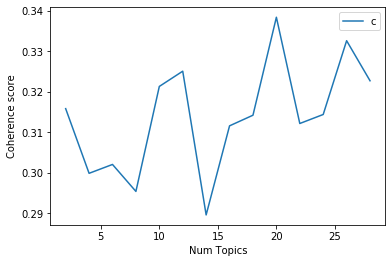

In [14]:
# Show graph
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [15]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3158
Num Topics = 4  has Coherence Value of 0.2999
Num Topics = 6  has Coherence Value of 0.302
Num Topics = 8  has Coherence Value of 0.2954
Num Topics = 10  has Coherence Value of 0.3213
Num Topics = 12  has Coherence Value of 0.3251
Num Topics = 14  has Coherence Value of 0.2896
Num Topics = 16  has Coherence Value of 0.3116
Num Topics = 18  has Coherence Value of 0.3142
Num Topics = 20  has Coherence Value of 0.3384
Num Topics = 22  has Coherence Value of 0.3122
Num Topics = 24  has Coherence Value of 0.3144
Num Topics = 26  has Coherence Value of 0.3326
Num Topics = 28  has Coherence Value of 0.3227


In [16]:
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.090*"feel" + 0.028*"year" + 0.025*"experience" + 0.024*"time" + '
  '0.021*"stop" + 0.020*"support" + 0.019*"lot" + 0.016*"valve" + '
  '0.016*"scare" + 0.015*"health"'),
 (1,
  '0.052*"people" + 0.050*"make" + 0.030*"medication" + 0.030*"question" + '
  '0.029*"read" + 0.028*"find" + 0.026*"post" + 0.026*"hospital" + '
  '0.019*"family" + 0.014*"happen"'),
 (2,
  '0.050*"heart" + 0.045*"test" + 0.037*"year" + 0.037*"problem" + '
  '0.027*"cardiologist" + 0.024*"show" + 0.021*"due" + 0.020*"bad" + '
  '0.019*"result" + 0.018*"age"'),
 (3,
  '0.071*"pain" + 0.056*"feel" + 0.034*"chest" + 0.020*"hospital" + '
  '0.019*"bad" + 0.017*"feeling" + 0.017*"side" + 0.016*"leave" + '
  '0.016*"issue" + 0.015*"arm"'),
 (4,
  '0.047*"work" + 0.039*"find" + 0.037*"month" + 0.036*"stent" + 0.024*"time" '
  '+ 0.023*"put" + 0.022*"change" + 0.022*"fine" + 0.022*"artery" + '
  '0.022*"suffer"'),
 (5,
  '0.041*"give" + 0.026*"back" + 0.026*"morning" + 0.022*"minute" + '
  '0.020*"sit" + 0.020

In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)

# dominant topic in each post

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), 
                                                                  round(prop_topic,4), 
                                                                  topic_keywords]), 
                                                                  ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.2210,"heart, test, year, problem, cardiologist, show, due, bad, result, age",Hello I wonder if anyone has any advice. I have had a very stressful few months in my life. Last week I had breathing problems a shortness of breath with no pain. I went to urgent care who listened to my lungs and heart and said it was an anxiety attack. I went to my GP next day who said it was an anxiety attack to.\nSince then I have managed to ease the attacks but I've been experiencing some tingling of and on in left arm. Again a dull pain in left of chest just above the left breast. Again of and on . Does this sound like a heart attack is building ? Or could it. E the aftermath of anxiety . \nI am worried to go back to gp incase I am getting on there nerves.\nAlso would listening in with stethoscope show if there was a problem with the heart ? \nThanks in advance
1,1,0.0,0.1857,"feel, year, experience, time, stop, support, lot, valve, scare, health","Hi, I'm new here. Does anyone out there have Alcapa Syndrome, or had it corrected by surgery? I was diagnosed with this congenital defect in 2015 and have had 2 lots of open heart surgery to improve my prognosis. Alcapa Syndrome is SUCH a rare condition, it feels quite lonely being unable to share my experiences with another person who really understands the challenges. Thanks. \n\n"
2,2,8.0,0.1250,"exercise, day, week, advice, normal, low, run, diet, lose, eat","Hi, my dad had a double by pass op 4 days ago, he's X and op went well but he has been very confused and delusional since and it doesn't seem to be improving, has anyone had any experience of this?\n"
3,3,8.0,0.1496,"exercise, day, week, advice, normal, low, run, diet, lose, eat","Hi. I'm X. At the age of X, just having retired, I had a cardiac arrest 20 months ago. At the time it was terrifying, and although I've made a good recovery I still find myself weepy and depressed. I struggled hard to lose 3 stone in weight over the past months, and got my BMI to 25 but over the past few months I seem to have some sort of death wish, been eating all the wrong things and put half a stone back on. \nWondering if anyone could give me some advice as to why this is happening?\n"
4,4,7.0,0.1189,"day, week, start, home, wait, fit, appointment, bit, call, hour","hi, i' m X, I had a heart attack 4 weeks ago and now waiting to see cardio rehab, but they can t see me for a couple of weeks yet, so just resting and doing a spot of walking. \n"
5,5,0.0,0.2037,"feel, year, experience, time, stop, support, lot, valve, scare, health","Hi, I'm X. I'm X years old and was diagnosed with advanced heart failure just over 5.5 years ago while 31 weeks pregnant. My daughter was delivered the very next day (bit of a shock!) and we both started our journeys towards health/recovery. My daughter is doing great - loads of fun, loads of hard work, starting school soon, with no long-term ill effects from her early arrival as far as anyone can tell. Things for me are still not great. My heart is not at all what it should be, but has been stable for a few years now, and stable (as my consultant always likes to remind me) is good. I take lots of medication and have a CRT-D device fitted. I've spent the last few years really working on my mental health (with fantastic support from a BHF-funded psychologist as well as my GP and other health professions) and, now that I've made so much progress on that side of things, am hoping to make some progress with my physical health through lifestyle changes - diet, exercise etc.\n\nI'd love to hear from...\n* anyone who's doing their best to exercise (and/or diet) with a heart condition, maybe even someone looking for an online fitness buddy?\n* any ""women of child-bearing age"" (ugh!) with or without children\n* anyone who's managing to see their heart condition as a positive experience in any way (or living positively despite viewing their situation as negative)\n* anyone 

In [18]:
#most representative document for each topic

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(30)

Topic_Num  Topic_Perc_Contrib  \
0  0.0        0.2943               
1  1.0        0.3955               
2  2.0        0.3545               
3  3.0        0.4398               
4  4.0        0.3616               
5  5.0        0.4615               
6  6.0        0.3564               
7  7.0        0.4225               
8  8.0        0.4072               
9  9.0        0.4481               

                                                                         Keywords  \
0  feel, year, experience, time, stop, support, lot, valve, scare, health           
1  people, make, medication, question, read, find, post, hospital, family, happen   
2  heart, test, year, problem, cardiologist, show, due, bad, result, age            
3  pain, feel, chest, hospital, bad, feeling, side, leave, issue, arm               
4  work, find, month, stent, time, put, change, fine, artery, suffer                
5  give, back, morning, minute, sit, nurse, bed, put, happen, sleep                 
6  time, surgery, long, op, today, recovery, surgeon, hear, short, concern          
7  day, week, start, home, wait, fit, appointment, bit, call, hour                  
8  exercise, day, week, advice, normal, low, run, diet, lose, eat                   
9  good, heart, walk, thing, life, hope, great, live, body, happy                   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              